# NMFk: Unmixing Contaminated Groundwater

<div style="text-align: left; padding-top: 30px; padding-bottom: 30px;">
    <img src="https://raw.githubusercontent.com/SmartTensors/NMFk.jl/master/logo/nmfk-logo.png" alt="NMFk" width=20% max-width=125px;/>
</div>

**NMFk** is a code within our award winning [SmartTensors](https://github.com/SmartTensors) framework for unsupervised, supervised and physics-informed (scientific) machine learning (ML) and artificial intelligence (AI) ([web](https:///SmartTensors.com) [source](https://github.com/SmartTensors)).

<div style="text-align: left; padding-top: 30px; padding-bottom: 30px;">
    <img src="https://raw.githubusercontent.com/SmartTensors/NMFk.jl/master/logo/SmartTensorsNewSmall.png" alt="NMFk" width=20% max-width=125px;/>
</div>

**NMFk** performs Nonnegative Matrix Factorization with $k$-means clustering.

The example problem presented here is demonstrating how **NMFk** can be applied to unmix groundwater.

Here, the dataset analyzed by **NMFk** includes a series of hydrogeochemical concentrations observed at monitoring wells.

This type of analysis can also be called **blind source separation** or **feature extraction**.

In general, applying **NMFk**, we can automatically:

- identify the number of the unknown mixed signatures in a dataset 
- estimate the shape of the unknown mixed signatures
- estimate how the signatures are mixed at each sensor

## Setup

If **NMFk** is not installed, first execute in the Julia REPL: 

```julia
import Pkg
Pkg.add("NMFk")
Pkg.add("Mads")
Pkg.add("Cairo")
Pkg.add("Fontconfig")
Pkg.add("Gadfly")
```

In [1]:
import NMFk
import Cairo
import Fontconfig
import Gadfly
import Random

┌ Info: Precompiling NMFk [e40cd9e2-a1df-5d90-a1fa-603fdc3dbdd8]
└ @ Base loading.jl:1317


Mads: Model Analysis & Decision Support
====

    ___      ____            ____    ____              ______
   /   \    /    \          /    |  |    \            /  __  \
  |     \  /     |         /     |  |     \          /  /  \__\
  |  |\  \/  /|  |        /      |  |      \        |  |
  |  | \    / |  |       /  /|   |  |   |\  \        \  \______.
  |  |  \__/  |  |      /  / |   |  |   | \  \        \_______  \
  |  |        |  |     /  /  |   |  |   |  \  \               \  \
  |  |        |  |    /  /===|   |  |   |___\  \    __.        |  |
  |  |        |  |   /  /    |   |  |           \   \  \______/  /
  |__|        |__|  /__/     |___|  |____________\   \__________/

MADS is an integrated high-performance computational framework for data- and model-based analyses.
MADS can perform: Sensitivity Analysis, Parameter Estimation, Model Inversion and Calibration, Uncertainty Quantification, Model Selection and Model Averaging, Model Reduction and Surrogate Modeling, Machine L

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
[ Info: Module BIGUQ is not available!


NMFk: Nonnegative Matrix Factorization + k-means clustering and physics constraints
====

  _     _   _      _   _______   _
 |  \  | | |  \  /  | |  _____| | |  _
 | . \ | | | . \/ . | | |___    | | / /
 | |\ \| | | |\  /| | |  ___|   | |/ /
 | | \ ' | | | \/ | | | |       |   (
 | |  \  | | |    | | | |       | |\ \
 |_|   \_| |_|    |_| |_|       |_| \_\

NMFk performs unsupervised machine learning based on matrix decomposition coupled with various constraints.
NMFk provides automatic identification of the optimal number of signals (features) present in two-dimensional data arrays (matrices).
NMFk offers visualization, pre-, and post-processing capabilities.


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7578890895572376393\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-996381830850543884\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7578890895572376393\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")


Let us assume that there are multiple wells (monitoring points) detecting simultaneously multiple signals (here, contaminant plumes with different chemical signatures).

Our goal is to estimate automatically the number of signals (plumes) using unsupervised machine learning (ML).

In the example presented here, we assume that there are 20 wells (monitoring points), 2 sources (contaminant plumes), and 3 chemical species (e.g., nitrate, sulfate, chloride) detected at each well.

These types of unsupervised machine learning analyses are applicable in many other situations where the mixing of signals (volumes/mass) is constrained by volumetric or weight constraints.

For example, these types of problems occur in the case of mass transport in fluids (e.g., atmosphere, oceans, watersheds, oil/gas/geothermal reservoirs, aquifers, etc.).

Let us assume that there are 20 measurement locations (wells), 2 contaminant sources, and 3 geochemical species:

In [2]:
nWells = 20
nSources = 2
nSpecies = 3
Random.seed!(2015);

Due to volumetric constraints, mixing coefficients of the different sources (plumes) at each of well (observation point) have to add to 1.

The mixing matrix `W` is defined as:

In [3]:
W = rand(nWells, nSources)
for i = 1:nWells
	W[i, :] ./= sum(W[i, :])
end
display(W)

20×2 Matrix{Float64}:
 0.395136  0.604864
 0.231592  0.768408
 0.351722  0.648278
 0.562318  0.437682
 0.476007  0.523993
 0.547533  0.452467
 0.446452  0.553548
 0.499894  0.500106
 0.601403  0.398597
 0.267675  0.732325
 0.592915  0.407085
 0.55854   0.44146
 0.735353  0.264647
 0.364806  0.635194
 0.121244  0.878756
 0.788195  0.211805
 0.245554  0.754446
 0.818814  0.181186
 0.450388  0.549612
 0.507392  0.492608

Here, `W` defines 2 mixing values for each of the 20 observation points.

The 2 mixing values define how the 2 sources (signals) are mixed at each well.

The mixing values for each well (along each row) add up to 1.

Let us also define `H` as a matrix which specifies the concentrations of the 3 chemical species present in the 2 contaminant sources:

In [4]:
H = [100 0 3; 5 10 20]

2×3 Matrix{Int64}:
 100   0   3
   5  10  20

Here, the first source (row 1) has elevated concentration for the first chemical component (100).

The second source (row 2) has elevated concentrations for the second (10) and third (20) chemical species.

Now for this synthetic problem, we can compute the synthetic observed concentrations at each the wells `X` as:

In [5]:
X = W * H

20×3 Matrix{Float64}:
 42.5379  6.04864  13.2827
 27.0013  7.68408  16.0629
 38.4136  6.48278  14.0207
 58.4202  4.37682  10.4406
 50.2206  5.23993  11.9079
 57.0156  4.52467  10.6919
 47.413   5.53548  12.4103
 52.4899  5.00106  11.5018
 62.1333  3.98597   9.77616
 30.4291  7.32325  15.4495
 61.3269  4.07085   9.92044
 58.0613  4.4146   10.5048
 74.8585  2.64647   7.49901
 39.6565  6.35194  13.7983
 16.5182  8.78756  17.9389
 79.8785  2.11805   6.60068
 28.3277  7.54446  15.8256
 82.7873  1.81186   6.08016
 47.7869  5.49612  12.3434
 53.2022  4.92608  11.3743

We can also make some of the observations ''missing'' by setting respective matrix entries equal to **NaN**:

In [6]:
X[1, 1] = NaN
display(X)

20×3 Matrix{Float64}:
 NaN       6.04864  13.2827
  27.0013  7.68408  16.0629
  38.4136  6.48278  14.0207
  58.4202  4.37682  10.4406
  50.2206  5.23993  11.9079
  57.0156  4.52467  10.6919
  47.413   5.53548  12.4103
  52.4899  5.00106  11.5018
  62.1333  3.98597   9.77616
  30.4291  7.32325  15.4495
  61.3269  4.07085   9.92044
  58.0613  4.4146   10.5048
  74.8585  2.64647   7.49901
  39.6565  6.35194  13.7983
  16.5182  8.78756  17.9389
  79.8785  2.11805   6.60068
  28.3277  7.54446  15.8256
  82.7873  1.81186   6.08016
  47.7869  5.49612  12.3434
  53.2022  4.92608  11.3743

## Analysis

Now assuming that only `X` is **known**, **NMFk** can estimate **unknown** `W` and `H`.

**NMFk** estimates *automatically* the number signals (features; here, contaminant sources) present in the analyzed dataset `X`.

The number of signals is equal to the number of columns in `W` and the number of rows in `H`.

**NMFk** computes the number signals (features) based on silhouettes of the k-means clusters obtained from a series of **NMF** solutions using random initial guesses ([see the papers and presentations at http://SmartTensors.com for more details](http://SmartTensors.com)).

**NMFk** execution produces:

In [7]:
We, He, fit, sil, aic, kopt = NMFk.execute(X, 2:5; save=false, mixture=:mixmatch);


OF: min 1.4554483701327668e-28 max 7.47495011503485e-28 mean 3.5818722439625802e-28 std 1.8428879806645485e-28
Worst correlation by columns: 24.25443446773559
Worst correlation by rows: 3.4234728934046044
Worst norm by columns: 0.7244014973422612
Worst norm by rows: 0.8854792526599767
Signals:  2 Fit:     1.766171 Silhouette:    0.9992961 AIC:    -155.0147


┌ Warning: OF 1 is very different: 4.564053374769316e-28 vs 2.410463103515954e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 2 is very different: 6.338990411516593e-28 vs 4.295840666994172e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 3 is very different: 3.8634462833199053e-28 vs 1.4554483701327668e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 4 is very different: 5.565413686334238e-28 vs 4.057210243164816e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 5 is very different: 3.9758589623138995e-28 vs 3.441898737092427e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 6 is very different: 1.9075642764375592e-28 vs 2.025893412220711e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 7 is very different: 7.427125422655826e-28 vs 7.47495011503485e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ W


OF: min 1.2390046592627517e-28 max 7.79443878164936e-28 mean 4.897642930064652e-28 std 2.4718326083729908e-28
Worst correlation by columns: 24.25443446773559
Worst correlation by rows: 3.4234728934046044
Worst norm by columns: 0.37735459673977706
Worst norm by rows: 0.9785524071916302
Signals:  3 Fit:     389.8159 Silhouette:   -0.3976257 AIC:     209.4001


┌ Warning: OF 1 is very different: 5.922373245946746e-28 vs 1.501300910248738e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 2 is very different: 4.896854069159431e-28 vs 5.520054184284031e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 3 is very different: 4.840154691596671e-28 vs 5.44757758861685e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 4 is very different: 3.609038641386129e-28 vs 6.5495176655974505e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 5 is very different: 6.129449233567262e-28 vs 6.167413164631024e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 6 is very different: 4.610891991016814e-28 vs 2.0002554328010283e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 7 is very different: 1.053178612276627e-27 vs 7.79443878164936e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warn


OF: min 2.8995568647529815e-28 max 1.0801477944738704e-27 mean 5.598102110094334e-28 std 2.4295935949002035e-28
Worst correlation by columns: 24.254434467735578
Worst correlation by rows: 3.4234728934046053
Worst norm by columns: 0.43165856174070105
Worst norm by rows: 0.9295886300386029
Signals:  4 Fit:     18.91068 Silhouette: -0.003741637 AIC:     76.86919


┌ Warning: OF 1 is very different: 4.853959757438038e-28 vs 4.096653288425867e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 2 is very different: 7.297456411360122e-28 vs 4.686326815078573e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 3 is very different: 3.4399265848293746e-28 vs 3.765331708233042e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 4 is very different: 7.817611570740227e-28 vs 7.772745106755782e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 5 is very different: 2.9212505396465593e-28 vs 2.8995568647529815e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 6 is very different: 6.756593653217966e-28 vs 6.5120467725994525e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 7 is very different: 4.113909620727577e-28 vs 3.727860815235044e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ 


OF: min 3.2086917319864655e-28 max 1.165394076044316e-27 mean 6.708325226579756e-28 std 2.465412388089541e-28
Worst correlation by columns: 24.25443446773559
Worst correlation by rows: 3.423472893404604
Worst norm by columns: 0.4939411913907223
Worst norm by rows: 0.9514165071963728
Signals:  5 Fit:     1118.919 Silhouette:   -0.2930927 AIC:     363.6122
Signals:  2 Fit:     1.766171 Silhouette:    0.9992961 AIC:    -155.0147
Signals:  3 Fit:     389.8159 Silhouette:   -0.3976257 AIC:     209.4001
Signals:  4 Fit:     18.91068 Silhouette: -0.003741637 AIC:     76.86919
Signals:  5 Fit:     1118.919 Silhouette:   -0.2930927 AIC:     363.6122


┌ Warning: OF 1 is very different: 8.30128191325386e-28 vs 5.684235860183153e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 2 is very different: 6.97599559248256e-28 vs 6.392238522619011e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 3 is very different: 1.1438976163770434e-27 vs 8.42552750582617e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 4 is very different: 9.188257393561735e-28 vs 9.282920702188256e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 5 is very different: 4.561588184440501e-28 vs 5.902651723316221e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 6 is very different: 2.230997247578174e-28 vs 3.2086917319864655e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warning: OF 7 is very different: 7.425153270392774e-28 vs 6.565294883701872e-28!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:413
┌ Warni

Above, **NMFk** provides estimates of `W` and `H` (`We` and `He`).
These are vectors of matrices for a different number of sources. For example, `We[2]`, `We[3]`, ..., `He[2]`, `He[3]`, ... .

The **NMFk** analyses are performed for the number of sources varying between 2 and 5 (`2:5`).

**NMFk** also returns the reconstruction error (`fit`); here, `fit` is a Frobenius norm between the **known** `X` and estimated `Xe` where `Xe` is computed as, for example, `We[2] * He[2]`.

**NMFk** also provides the silhouettes of the k-means clusters (`sil`)

`fit` and `sil` are vectors with estimates for a different number of sources.

The automatically estimated number of features (plumes) `kopt` is returned as well.

In the example above, `kopt` is equal to 2, which matches the **true** **unknown** number of sources.

The estimated concentrations of geochemical species for the 3 sources are:

In [8]:
He[2]

2×3 Matrix{Float64}:
  7.04508  9.78473   19.634
 92.5568   0.783493   4.33194

The concentration estimates are very close to the actual values `H` (note that the matrix rows are not expected to be in the same order for estimated and true `H` matrices):

In [9]:
H

2×3 Matrix{Int64}:
 100   0   3
   5  10  20

The estimated mixing coefficient at the 20 wells are:

In [10]:
We[2]

20×2 Matrix{Float64}:
 0.581486  0.418514
 0.763244  0.236756
 0.629735  0.370265
 0.395684  0.604316
 0.491608  0.508392
 0.412116  0.587884
 0.524454  0.475546
 0.465061  0.534939
 0.352247  0.647753
 0.723143  0.276857
 0.361679  0.638321
 0.399882  0.600118
 0.203378  0.796622
 0.615194  0.384806
 0.885883  0.114117
 0.14465   0.85535
 0.747727  0.252273
 0.110621  0.889379
 0.52008   0.47992
 0.456728  0.543272

They are also very close to the actual values (note that the matrix columns are not expected to be in the same order for estimated and true `W` matrices):

In [11]:
W

20×2 Matrix{Float64}:
 0.395136  0.604864
 0.231592  0.768408
 0.351722  0.648278
 0.562318  0.437682
 0.476007  0.523993
 0.547533  0.452467
 0.446452  0.553548
 0.499894  0.500106
 0.601403  0.398597
 0.267675  0.732325
 0.592915  0.407085
 0.55854   0.44146
 0.735353  0.264647
 0.364806  0.635194
 0.121244  0.878756
 0.788195  0.211805
 0.245554  0.754446
 0.818814  0.181186
 0.450388  0.549612
 0.507392  0.492608

These matrices can be also easily ploted:

In [12]:
NMFk.plotmatrix(We[2])

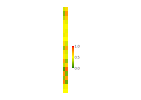

In [13]:
NMFk.plotmatrix(W)

In [14]:
NMFk.plotmatrix(He[2])

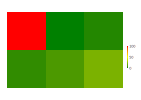

In [15]:
NMFk.plotmatrix(H)

In conclusion, **NMFk** successfully estimated the number of plumes, the original concentrations at the contaminant sources (before mixing in the aquifer), and the mixing coefficients at each well.

The **NMFk** unsupervised ML analyses are unbiased and robust.